In [18]:
# 기존에 잘못 내려받은 파일 정리
!rm -f ./NanumGothic.ttf ./NotoSansCJKkr-Regular.otf

# 구글 공식 저장소에서 OTF를 직접 다운로드 (-L 로 리다이렉트 추적)
!curl -L -o NotoSansCJKkr-Regular.otf \
  https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/Korean/NotoSansCJKkr-Regular.otf

# 진짜 폰트가 내려왔는지 확인 (OTF여야 정상)
!file NotoSansCJKkr-Regular.otf
!ls -lh NotoSansCJKkr-Regular.otf


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 15.6M  100 15.6M    0     0  8247k      0  0:00:01  0:00:01 --:--:-- 13.9M
NotoSansCJKkr-Regular.otf: OpenType font data
-rw-rw-rw- 1 codespace codespace 16M Aug 13 09:50 NotoSansCJKkr-Regular.otf


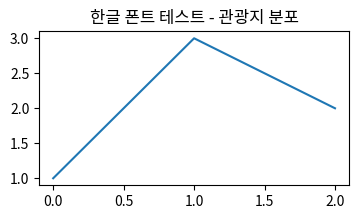

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# 폰트 등록
font_manager.fontManager.addfont('NotoSansCJKkr-Regular.otf')

# 전역 설정
rcParams['font.family'] = 'Noto Sans CJK KR'
rcParams['axes.unicode_minus'] = False

# 캐시 무시하고 다시 로드 (중요)
mpl.font_manager._load_fontmanager(try_read_cache=False)

# 테스트
plt.figure(figsize=(4,2))
plt.title("한글 폰트 테스트 - 관광지 분포")
plt.plot([0,1,2],[1,3,2])
plt.show()


In [2]:
import os
# notebooks 폴더에서 한 단계 위로 이동
os.chdir("..")
print("현재 작업폴더:", os.getcwd())


현재 작업폴더: /workspaces/smart_travel_planner


In [3]:
import pandas as pd

df = pd.read_json("data/raw/20250812/pois.json")
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   baseYm           20 non-null     int64 
 1   tAtsCd           20 non-null     object
 2   tAtsNm           20 non-null     object
 3   areaCd           20 non-null     int64 
 4   areaNm           20 non-null     object
 5   signguCd         20 non-null     int64 
 6   signguNm         20 non-null     object
 7   rlteTatsCd       20 non-null     object
 8   rlteTatsNm       20 non-null     object
 9   rlteRegnCd       20 non-null     int64 
 10  rlteRegnNm       20 non-null     object
 11  rlteSignguCd     20 non-null     int64 
 12  rlteSignguNm     20 non-null     object
 13  rlteCtgryLclsNm  20 non-null     object
 14  rlteCtgryMclsNm  20 non-null     object
 15  rlteCtgrySclsNm  20 non-null     object
 16  rlteRank         20 non-null     int64 
dtypes: int64(6), object(11)
memory usage:

In [4]:
!pip install pandas matplotlib pyarrow



# Day 2 — EDA for Related POIs (TarRlteTarService1)

이 노트북은 `data/raw/YYYYMMDD/pois.json` 파일을 자동으로 탐색해
EDA(탐색적 데이터 분석)와 전처리 설계를 빠르게 진행할 수 있도록 구성되었습니다.

## 오늘 목표
1. 데이터 구조/분포 파악 (`info`, 컬럼별 통계/결측/중복)
2. 카테고리/지역 분포 시각화
3. 중심 관광지별 연관 관광지 수 파악
4. 전처리 방향 및 추천 로직 설계 메모

> ⚠️ 그래프는 `matplotlib`만 사용합니다(환경 제약).


In [5]:

import os
import json
from datetime import datetime
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 디렉토리 (필요 시 여기만 바꾸면 됩니다)
PROJECT_ROOT = Path.cwd()  # 노트북을 리포 루트에서 여는 경우 자동으로 맞춰짐
CANDIDATE_DIRS = [
    PROJECT_ROOT / "data" / "raw",       # 리포 구조
    Path("data/raw"),                    # 상대 경로 대안
]

def find_latest_pois():
    for raw_dir in CANDIDATE_DIRS:
        if raw_dir.exists():
            # yyyyMMdd 폴더 중 가장 최근
            dates = sorted([p for p in raw_dir.iterdir() if p.is_dir()], reverse=True)
            for d in dates:
                f = d / "pois.json"
                if f.exists():
                    return f
    # 샘플 폴더 폴백
    sample = PROJECT_ROOT / "data" / "sample" / "pois.json"
    if sample.exists():
        return sample
    return None

pois_path = find_latest_pois()
pois_path


PosixPath('/workspaces/smart_travel_planner/data/raw/20250813/pois.json')

In [6]:

if pois_path is None:
    raise FileNotFoundError("데이터 파일을 찾을 수 없습니다. data/raw/YYYYMMDD/pois.json 또는 data/sample/pois.json 을 준비하세요.")
df = pd.read_json(pois_path)
print(f"Loaded: {pois_path}")
print("- rows:", len(df), "| cols:", len(df.columns))
df.head(3)


Loaded: /workspaces/smart_travel_planner/data/raw/20250813/pois.json
- rows: 20 | cols: 17


,baseYm,tAtsCd,tAtsNm,areaCd,areaNm,signguCd,signguNm,rlteTatsCd,rlteTatsNm,rlteRegnCd,rlteRegnNm,rlteSignguCd,rlteSignguNm,rlteCtgryLclsNm,rlteCtgryMclsNm,rlteCtgrySclsNm,rlteRank
0,202504,3dbadaccd57c18ae536e552040025fa8,간현관광지,51,강원특별자치도,51130,원주시,0bfeca2105aa7bf8d83e4622e5da19ec,뮤지엄산,51,강원특별자치도,51130,원주시,관광지,문화관광,전시시설,1
1,202504,3dbadaccd57c18ae536e552040025fa8,간현관광지,51,강원특별자치도,51130,원주시,85f72636fc5aa3de9bcabe7b39daa546,스톤크릭,51,강원특별자치도,51130,원주시,음식,음식,카페/찻집,2
2,202504,3dbadaccd57c18ae536e552040025fa8,간현관광지,51,강원특별자치도,51130,원주시,d9f35cb4dfb3a3f0dd79c49eacd30625,구룡사,51,강원특별자치도,51130,원주시,관광지,역사관광,종교성지,3


In [7]:

print("=== DataFrame Info ===")
print(df.info())

print("\n=== Null counts ===")
print(df.isna().sum())

print("\n=== Duplicates ===")
print("Total duplicates:", df.duplicated().sum())


=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   baseYm           20 non-null     int64 
 1   tAtsCd           20 non-null     object
 2   tAtsNm           20 non-null     object
 3   areaCd           20 non-null     int64 
 4   areaNm           20 non-null     object
 5   signguCd         20 non-null     int64 
 6   signguNm         20 non-null     object
 7   rlteTatsCd       20 non-null     object
 8   rlteTatsNm       20 non-null     object
 9   rlteRegnCd       20 non-null     int64 
 10  rlteRegnNm       20 non-null     object
 11  rlteSignguCd     20 non-null     int64 
 12  rlteSignguNm     20 non-null     object
 13  rlteCtgryLclsNm  20 non-null     object
 14  rlteCtgryMclsNm  20 non-null     object
 15  rlteCtgrySclsNm  20 non-null     object
 16  rlteRank         20 non-null     int64 
dtypes: int64(6), o


## 컬럼 의미(요약)

- **baseYm**: 기준연월(YYYYMM)
- **tAtsNm**: 중심 관광지 명
- **tAtsCd**: 중심 관광지 코드
- **areaNm / signguNm**: 중심 관광지의 시/도, 시/군/구
- **rlteTatsNm**: 연관 관광지 명
- **rlteTatsCd**: 연관 관광지 코드
- **rlteRegnNm / rllteSignguNm**: 연관 관광지 지역
- **rlteCtgryLclsNm / MclsNm / SclsNm**: 연관 관광지 카테고리(대/중/소)
- **rlteRank**: 연관도 순위 (문자형일 수 있으니 숫자 변환 시 주의)


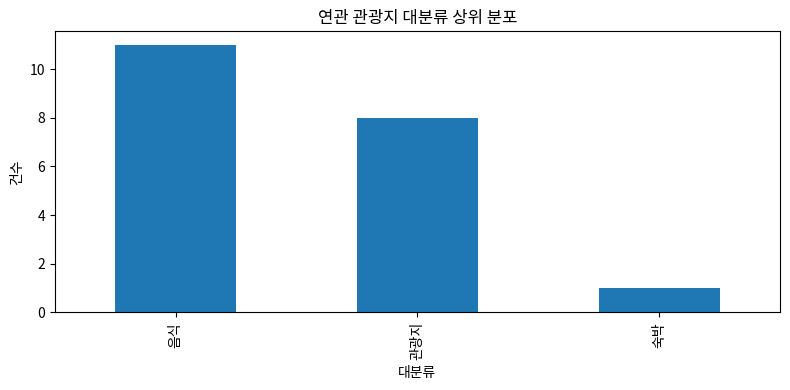

In [20]:

# 카테고리(대분류) 분포
ax = df['rlteCtgryLclsNm'].value_counts().head(15).plot(kind='bar', figsize=(8,4))
ax.set_title("연관 관광지 대분류 상위 분포")
ax.set_xlabel("대분류")
ax.set_ylabel("건수")
plt.tight_layout()
plt.show()


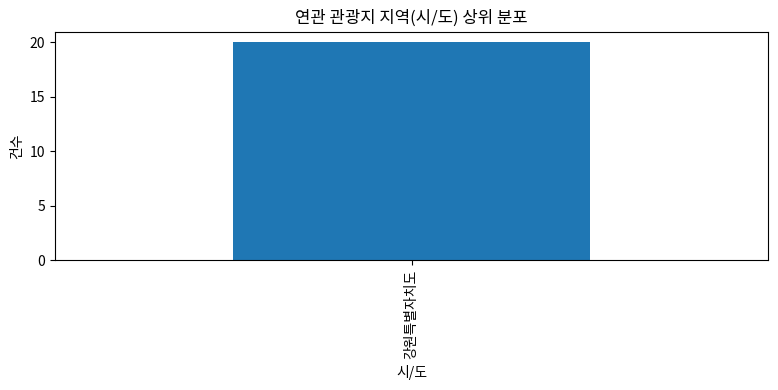

In [21]:

# 지역(시/도) 분포
ax = df['rlteRegnNm'].value_counts().head(15).plot(kind='bar', figsize=(8,4))
ax.set_title("연관 관광지 지역(시/도) 상위 분포")
ax.set_xlabel("시/도")
ax.set_ylabel("건수")
plt.tight_layout()
plt.show()


tAtsNm
간현관광지    20
Name: rlteTatsNm, dtype: int64


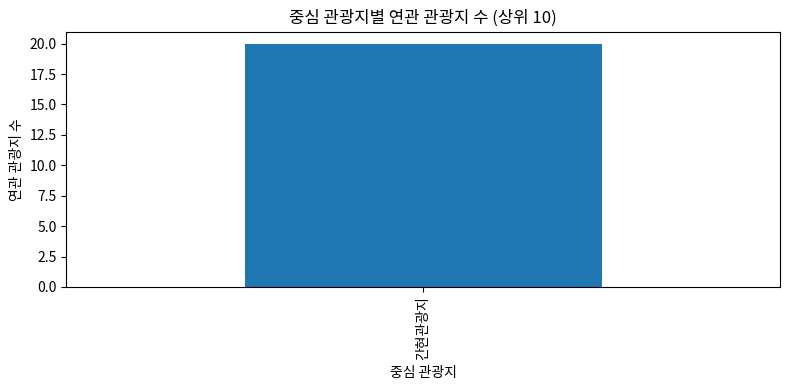

In [22]:

# 중심 관광지별 연결된 연관 관광지 수
g = df.groupby('tAtsNm')['rlteTatsNm'].nunique().sort_values(ascending=False)
print(g.head(10))
ax = g.head(10).plot(kind='bar', figsize=(8,4))
ax.set_title("중심 관광지별 연관 관광지 수 (상위 10)")
ax.set_xlabel("중심 관광지")
ax.set_ylabel("연관 관광지 수")
plt.tight_layout()
plt.show()


In [23]:

# 전처리 초안: 문자열 트림 & 순위 숫자화 컬럼 추가
df_clean = df.copy()
for col in ['tAtsNm','rlteTatsNm','areaNm','signguNm','rlteRegnNm','rlteSignguNm',
            'rlteCtgryLclsNm','rlteCtgryMclsNm','rlteCtgrySclsNm']:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).str.strip()

# rlteRank → 정수
if 'rlteRank' in df_clean.columns:
    df_clean['rlteRank_num'] = pd.to_numeric(df_clean['rlteRank'], errors='coerce')

print(df_clean[['tAtsNm','rlteTatsNm','rlteCtgryLclsNm','rlteRank','rlteRank_num']].head(10))


  tAtsNm   rlteTatsNm rlteCtgryLclsNm  rlteRank  rlteRank_num
0  간현관광지         뮤지엄산             관광지         1             1
1  간현관광지         스톤크릭              음식         2             2
2  간현관광지          구룡사             관광지         3             3
3  간현관광지          로톤다              음식         4             4
4  간현관광지       오크밸리CC             관광지         5             5
5  간현관광지   미로예술원주중앙시장             관광지         6             6
6  간현관광지         주문진항             관광지         7             7
7  간현관광지     오크밸리/콘도A              숙박         8             8
8  간현관광지         소복소복              음식         9             9
9  간현관광지  평창한우마을/봉화산점              음식        10            10


In [24]:

# 정리본(미니) 저장: notebooks/output/clean_preview.parquet
out_dir = Path("notebooks") / "output"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "clean_preview.parquet"
df_clean.head(1000).to_parquet(out_path, index=False)
print("Saved:", out_path.resolve())


Saved: /workspaces/smart_travel_planner/notebooks/output/clean_preview.parquet



## 전처리/추천 설계 메모 (작성란)

- 문자열 컬럼 정규화: 공백 제거, 대/소문자 통일 여부
- `baseYm` → `datetime` 변환 및 최신월만 사용?
- 카테고리 계층 표준화(대/중/소의 누락 값 처리)
- 지역 코드→이름 매핑(필요 시 외부 테이블 사용)
- 중복 처리: 동일 (tAtsNm, rltetatsNm) 쌍 중 상위 rank만 사용
- 추천 로직 MVP:
  1) 입력: (지역, 카테고리, 중심 관광지 옵션)
  2) 필터: 지역/카테고리로 하위셋 만들기
  3) 정렬: rlteRank_num 오름차순(=순위가 낮을수록 상위) 또는 기존 문자열 rank를 숫자화
  4) 상위 N개 반환 + 중복/유사명 정리
- 차주(또는 3일차): 간단한 UI(예: Streamlit)에서 사용자 선호를 받아 추천 결과 표시


In [25]:
import pandas as pd

df = pd.read_parquet("data/processed/clean_pois.parquet")
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   baseYm           20 non-null     int64         
 1   baseYm_dt        20 non-null     datetime64[ns]
 2   tAtsNm           20 non-null     object        
 3   areaNm           20 non-null     object        
 4   signguNm         20 non-null     object        
 5   rlteTatsNm       20 non-null     object        
 6   rlteRegnNm       20 non-null     object        
 7   rlteSignguNm     20 non-null     object        
 8   rlteCtgryLclsNm  20 non-null     object        
 9   rlteCtgryMclsNm  20 non-null     object        
 10  rlteCtgrySclsNm  20 non-null     object        
 11  rlteRank         20 non-null     int64         
 12  rlteRank_num     20 non-null     int64         
 13  tAtsCd           20 non-null     object        
 14  areaCd           20 non-null     int64      

,baseYm,baseYm_dt,tAtsNm,areaNm,signguNm,rlteTatsNm,rlteRegnNm,rlteSignguNm,rlteCtgryLclsNm,rlteCtgryMclsNm,rlteCtgrySclsNm,rlteRank,rlteRank_num,tAtsCd,areaCd,signguCd,rlteTatsCd,rlteRegnCd,rlteSignguCd
0,202504,2025-04-01,간현관광지,강원특별자치도,원주시,뮤지엄산,강원특별자치도,원주시,관광지,문화관광,전시시설,1,1,3dbadaccd57c18ae536e552040025fa8,51,51130,0bfeca2105aa7bf8d83e4622e5da19ec,51,51130
1,202504,2025-04-01,간현관광지,강원특별자치도,원주시,스톤크릭,강원특별자치도,원주시,음식,음식,카페/찻집,2,2,3dbadaccd57c18ae536e552040025fa8,51,51130,85f72636fc5aa3de9bcabe7b39daa546,51,51130
2,202504,2025-04-01,간현관광지,강원특별자치도,원주시,구룡사,강원특별자치도,원주시,관광지,역사관광,종교성지,3,3,3dbadaccd57c18ae536e552040025fa8,51,51130,d9f35cb4dfb3a3f0dd79c49eacd30625,51,51130
3,202504,2025-04-01,간현관광지,강원특별자치도,원주시,로톤다,강원특별자치도,원주시,음식,음식,카페/찻집,4,4,3dbadaccd57c18ae536e552040025fa8,51,51130,dd8a95d77bf09cf6de90b7688798b9bf,51,51130
4,202504,2025-04-01,간현관광지,강원특별자치도,원주시,오크밸리CC,강원특별자치도,원주시,관광지,레저스포츠,육상레저스포츠,5,5,3dbadaccd57c18ae536e552040025fa8,51,51130,0b37553854f416b46ded92602ff89444,51,51130


In [26]:
df.describe(include="all")


,baseYm,baseYm_dt,tAtsNm,areaNm,signguNm,rlteTatsNm,rlteRegnNm,rlteSignguNm,rlteCtgryLclsNm,rlteCtgryMclsNm,rlteCtgrySclsNm,rlteRank,rlteRank_num,tAtsCd,areaCd,signguCd,rlteTatsCd,rlteRegnCd,rlteSignguCd
count,20.0,20,20,20,20,20,20,20,20,20,20,20.00000,20.00000,20,20.0,20.0,20,20.0,20.000000
unique,NaN,NaN,1,1,1,20,1,3,3,7,11,NaN,NaN,1,NaN,NaN,20,NaN,NaN
top,NaN,NaN,간현관광지,강원특별자치도,원주시,뮤지엄산,강원특별자치도,원주시,음식,음식,한식,NaN,NaN,3dbadaccd57c18ae536e552040025fa8,NaN,NaN,0bfeca2105aa7bf8d83e4622e5da19ec,NaN,NaN
freq,NaN,NaN,20,20,20,1,20,18,11,11,6,NaN,NaN,20,NaN,NaN,1,NaN,NaN
mean,202504.0,2025-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.50000,10.50000,NaN,51.0,51130.0,NaN,51.0,51162.500000
min,202504.0,2025-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,1.00000,NaN,51.0,51130.0,NaN,51.0,51130.000000
25%,202504.0,2025-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.75000,5.75000,NaN,51.0,51130.0,NaN,51.0,51130.000000
50%,202504.0,2025-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.50000,10.50000,NaN,51.0,51130.0,NaN,51.0,51130.000000
75%,202504.0,2025-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.25000,15.25000,NaN,51.0,51130.0,NaN,51.0,51130.000000
max,202504.0,2025-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.00000,20.00000,NaN,51.0,51130.0,NaN,51.0,51760.000000


In [27]:
df.isna().sum()


baseYm             0
baseYm_dt          0
tAtsNm             0
areaNm             0
signguNm           0
rlteTatsNm         0
rlteRegnNm         0
rlteSignguNm       0
rlteCtgryLclsNm    0
rlteCtgryMclsNm    0
rlteCtgrySclsNm    0
rlteRank           0
rlteRank_num       0
tAtsCd             0
areaCd             0
signguCd           0
rlteTatsCd         0
rlteRegnCd         0
rlteSignguCd       0
dtype: int64

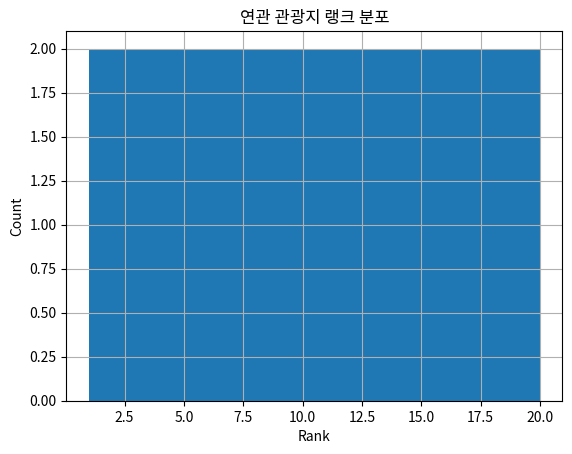

In [28]:
import matplotlib.pyplot as plt

df["rlteRank_num"].hist()
plt.xlabel("Rank")
plt.ylabel("Count")
plt.title("연관 관광지 랭크 분포")
plt.show()


In [4]:
import os, pathlib
os.chdir("..")  # notebooks에서 리포 루트로 한 단계 올라감
print("CWD:", os.getcwd(), "| data exists?", (pathlib.Path("data/processed")).exists())


CWD: /workspaces/smart_travel_planner | data exists? True


In [5]:
import pandas as pd
df_final = pd.read_parquet("data/processed/final_pois.parquet")
display(df_final.sample(5))
df_final[["areaNm","signguNm","rlteCtgryLclsNm","rlteTatsNm","rlteRank_num"]].head(10)


,baseYm,baseYm_dt,areaNm,signguNm,tAtsNm,rlteTatsNm,rlteCtgryLclsNm,rlteCtgryMclsNm,rlteCtgrySclsNm,rlteRank_num,rlteRegnNm,rlteSignguNm,rlteRank,areaCd,signguCd
15,202504,2025-04-01,강원특별자치도,원주시,간현관광지,황금들밥/오크밸리월송점,음식,음식,한식,16,강원특별자치도,원주시,16,51,51130
16,202504,2025-04-01,강원특별자치도,원주시,간현관광지,사운드오브사일런스,음식,음식,카페/찻집,17,강원특별자치도,원주시,17,51,51130
14,202504,2025-04-01,강원특별자치도,원주시,간현관광지,민속풍물시장,관광지,쇼핑,시장,15,강원특별자치도,원주시,15,51,51130
6,202504,2025-04-01,강원특별자치도,원주시,간현관광지,주문진항,관광지,자연관광,자연경관(하천/해양),7,강원특별자치도,강릉시,7,51,51130
1,202504,2025-04-01,강원특별자치도,원주시,간현관광지,스톤크릭,음식,음식,카페/찻집,2,강원특별자치도,원주시,2,51,51130


,areaNm,signguNm,rlteCtgryLclsNm,rlteTatsNm,rlteRank_num
0,강원특별자치도,원주시,관광지,뮤지엄산,1
1,강원특별자치도,원주시,음식,스톤크릭,2
2,강원특별자치도,원주시,관광지,구룡사,3
3,강원특별자치도,원주시,음식,로톤다,4
4,강원특별자치도,원주시,관광지,오크밸리CC,5
5,강원특별자치도,원주시,관광지,미로예술원주중앙시장,6
6,강원특별자치도,원주시,관광지,주문진항,7
7,강원특별자치도,원주시,숙박,오크밸리/콘도A,8
8,강원특별자치도,원주시,음식,소복소복,9
9,강원특별자치도,원주시,음식,평창한우마을/봉화산점,10
